<p>This notebook shows the ability of the K-Means to take data and determine how far away from the hoop the shooter is.</p>

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import resample
from scipy.integrate import simps
from scipy.fftpack import fft
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm

In [29]:
dir = "C:/Users/我的电脑/desktop/Harvard/WearableDevicesAndComputerVision/project/data3/"

In [30]:
files = os.listdir(dir+'MultipleLocations_7_31')
md = pd.read_csv(dir+'motion_data.csv')

In [31]:
def trim_data(w,a):
    w2 = w['wx']**2 + w['wy']**2 + w['wz']**2
    a2 = a['ax']**2 + a['ay']**2 + a['az']**2
    center_index = w2.idxmax()
    empty_frame = (pd.DataFrame([],columns=w.columns),pd.DataFrame([],columns=a.columns))
    if w2.max()>2250000 and center_index-5>=0 and center_index+5<len(w2):
        start_index = center_index
        stop_index = center_index
        while (sum(list(w2[start_index:start_index+5]))/5 >50 or (w['time'][center_index]-w['time'][start_index])<200)\
        and start_index>1:
            start_index -= 1
        while sum(list(w2[stop_index-5:stop_index]))/5 >50 and stop_index<len(w2)-1:
            stop_index += 1
        start_time = w['time'][start_index]
        stop_time = w['time'][stop_index]
        w = w[w['time']>=start_time]
        w = w[w['time']<=stop_time]
        a = a[a['time']>=start_time]
        a = a[a['time']<=stop_time]
        w = w.reset_index()
        a = a.reset_index()
        return (w,a)
    else:
        return empty_frame

def get_v(w, a):
    g = np.sqrt(a['ax'][0]**2+a['ay'][0]**2+a['az'][0]**2)
    v = np.array([0, 0, 0])
    phi = np.arctan(a['ay'][0]/a['ax'][0])
    theta = np.arctan(np.sqrt(a['ax'][0]**2+a['ay'][0]**2)/a['az'][0])
    x = [1, 0, 0]
    y = [0, 1, 0]
    z = [0, 0, 1]
    Ry = [[np.cos(theta),0,-np.sin(theta)], [0,1,0], [np.sin(theta),1,np.cos(theta)]]
    Rz = [[np.cos(phi),-np.sin(phi),0], [np.sin(phi),np.cos(phi),0], [0,0,1]]
    xp = np.matmul(Rz,np.matmul(Ry,x))
    yp = np.matmul(Rz,np.matmul(Ry,y))
    zp = np.matmul(Rz,np.matmul(Ry,z))
    
    for n in range(len(w)-1):
        dt = (w['time'][n+1]-w['time'][n])/1000
        phi = np.arctan(a['ay'][0]/a['ax'][0])
        theta = np.arctan(np.sqrt(a['ax'][0]**2+a['ay'][0]**2)/a['az'][0])
        G = np.matmul(Rz,np.matmul(Ry,z))*g/1000*9.8
        v = v + (a['ax'][n]*xp+a['ay'][n]*yp+a['az'][n]*zp+G)*9.8/1000*dt
        wv = np.array([w['wx'][n], w['wy'][n], w['wz'][n]])*np.pi/180
        xn = xp + dt*np.cross(wv,xp)
        yn = yp + dt*np.cross(wv,yp)
        zn = zp + dt*np.cross(wv,zp)
        xp = xn/np.sqrt(np.dot(xn,xn))
        yp = yn/np.sqrt(np.dot(yn,yn))
        zp = zn/np.sqrt(np.dot(zn,zn))
    return v

In [74]:
md = pd.read_csv(dir+'motion_data.csv')
md_made = md[md['make']==1]
made_files = md_made['file_name'].to_string()

md_left = md[md['left']==1]
left_files = md_left['file_name'].to_string()

md_right = md[md['right']==1]
right_files = md_right['file_name'].to_string()

md_short = md[md['short']==1]
short_files = md_short['file_name'].to_string()

md_long = md[md['long']==1]
long_files = md_long['file_name'].to_string()


#df = pd.DataFrame([], columns=['ay_int', 'ay_mean', 'w_int', 'wxf', 'vx', 'vy', 'make', 'left',\
#                              'right', 'short', 'long', 'file_name'])
df = pd.DataFrame([], columns=['speed', 'vz', 'file_name'])

for file in tqdm(files):
    if 'w' in file:
        a = pd.read_csv(dir+'MultipleLocations_7_31/'+file.split('w.')[0]+'a.csv')
        w = pd.read_csv(dir+'MultipleLocations_7_31/'+file)
        w, a = trim_data(w, a)
        if len(w)>10:
            ay_int = simps(a['ay'],a['time'])
            ay_mean = a['ay'].mean()
            w_int = simps(np.sqrt(w['wx']**2+w['wy']**2+w['wz']**2),w['time'])
            v = get_v(w,a)
            vx = v[0]
            vy = v[1]
            vz = v[2]
            N = len(w['time'])
            T = (w['time'][N-1]-w['time'][0])/N/1000
            t = np.linspace(0.0, N*T, N)
            f = np.linspace(0.0, 1.0/2/T, N//2)
            uniform_wx= resample(w['wx'], N, w['time'])
            fft_wx = fft(uniform_wx[0])
            wxfs = 2/N*np.abs(fft_wx[0:N//2])
            wxf = f[np.where(wxfs==wxfs.max())[0][0]] 
            if file.split('w')[0] in made_files:
                results = [1, 0, 0, 0, 0]
            elif file.split('w')[0] in left_files:
                results = [0, 1, 0, 0, 0]
            elif file.split('w')[0] in right_files:
                results = [0, 0, 1, 0, 0]
            elif file.split('w')[0] in short_files:
                results = [0, 0, 0, 1, 0]
            elif file.split('w')[0] in long_files:
                results = [0, 0, 0, 0, 1]
                make = 0
#            df.loc[len(df)] = [ay_int, ay_mean, w_int, wxf, vx, vy]+results+[file.split('w')[0]]
#
            df.loc[len(df)] = [np.sqrt(vx**2+vy**2+vz**2), vz, file]
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in longlong_scalars


,speed,vz,file_name
0,2.180544,-0.908110,1596167636w.csv
1,2.696458,0.449686,1596167781w.csv
2,4.756637,4.350894,1596167850w.csv
3,2.111035,-0.153030,1596167913w.csv
4,3.756846,2.737777,1596167936w.csv


In [56]:
kmeans = KMeans(n_clusters=10)
data = df.drop(['file_name'], axis=1)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)

In [71]:
y_kmeans
locations = []
for n in range(10):
    locations.append(np.array(np.where(y_kmeans==n)).mean())
locations.sort()

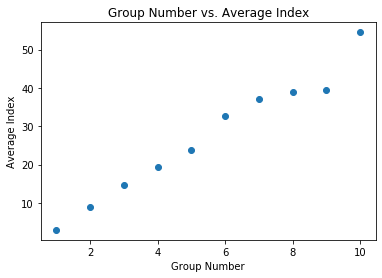

In [73]:
plt.scatter([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], locations)
plt.title('Group Number vs. Average Index')
plt.ylabel('Average Index')
plt.xlabel('Group Number')
plt.show()